In [40]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [41]:
data_dir = 'data'
train_dir = data_dir + '/train'
validation_dir = data_dir + '/validation'
test_dir = data_dir + '/test'

In [42]:
# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(), 
                                          transforms.RandomVerticalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=4, shuffle=True)
len(train_loader)


373

In [43]:
len(test_loader)

17

In [44]:
train_loader

In [45]:
# Build and train your network
# Transfer Learning
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(4096, 2)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [47]:
# Loss function and gradient descent

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [48]:
# Function for the validation pass
def validation(model, validation_loader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validation_loader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()
        probabilities = torch.exp(output)   
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [49]:
# Train the classifier
train_loss, test_loss = [], []
def train_classifier():
        epochs = 5
        steps = 0
        print_every = 40

        model.to('cuda')

        for e in range(epochs):
        
            model.train()
    
            running_loss = 0
    
            for images, labels in iter(train_loader):
        
                steps += 1
        
                images, labels = images.to('cuda'), labels.to('cuda')
        
                optimizer.zero_grad()
        
                output = model.forward(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                if steps % print_every == 0:
                
                    model.eval()
                
                    # Turn off gradients for validation, saves memory and computations
                    with torch.no_grad():
                        validation_loss, accuracy = validation(model, validation_loader, criterion)
                        train_loss.append(running_loss/print_every)
                        test_loss.append(validation_loss/len(validation_loader))    
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(validation_loss/len(validation_loader)),
                          "Validation Accuracy: {:.3f}".format(accuracy/len(validation_loader)))
            
                    running_loss = 0
                    model.train()
                    
train_classifier()

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 4.00 GiB total capacity; 2.53 GiB already allocated; 347.35 MiB free; 40.51 MiB cached)

In [ ]:
def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()
    model.to('cuda')

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            images, labels = images.to('cuda'), labels.to('cuda')
    
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy(model, test_loader)



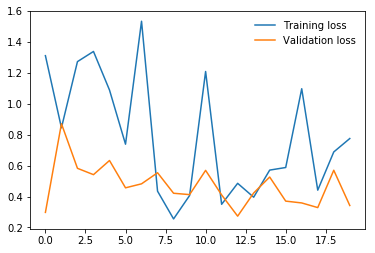

In [15]:
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [50]:
torch.save(model, 'firstVGG.pth')

In [53]:
model=torch.load('firstVGG.pth')

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 4.00 GiB total capacity; 2.64 GiB already allocated; 4.53 MiB free; 15.62 MiB cached)